In [1]:
# Show plots inline, and load main getdist plot module and samples class
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
import IPython
import pylab as mplot
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))
# matplotlib 2 may not work very well without usetex on, can uncomment
# plt.rcParams['text.usetex']=True



%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['figure.figsize'] = (16.,8.)
#import config

from chainconsumer import ChainConsumer


GetDist Version: 1.3.4, Matplotlib version: 3.1.1


In [2]:
def get_names(filename):
    """
    Function to obtain the names of the parameters of your chain
    """
    data = np.genfromtxt(filename, names=True)
    names = np.array(data.dtype.names)
    #print(names)
    #print(len(names))
    return names

def get_indices(filename, list_vars):
    """
    Function to obtain the index in a multinest chain from certain variables.
    """
    indices = []
    names = get_names(filename)
    for var in list_vars:
        indices.extend([i for i,n in enumerate(names) if var==n])
    #return indices, names[indices]
    return indices

def get_om_s8(filename):
    # might be useful later..
    data = np.loadtxt(filename)
    nsample = get_nsample(filename)
    data_params = []
    data_params.append([data[-nsample:,0], data[-nsample:,-3]*(data[-nsample:,0]/0.3)**(0.5)])
    data_params = np.array(data_params[0][:]).T
    weights = data[-nsample:,-1]
    return data_params, weights

def compute_s8(om, sigma_8):
    return sigma_8*(om/0.3)**0.5

In [3]:
dir = '../../data_vectors/gaussian_sims/071222/area12300/July14/chains/'
dir2 = '../../data_vectors/cosmodc2/2022/star_sample/Sep14/chains/'

nlbins = 5

name_plots = 'wcdm-comparison'

chainfile_0 = dir + 'gaussian_sims_3x2pt_fourier_w0-wa.txt'
name_gsims = r'Gaussian sims TXPipe + FireCrown' 

chainfile_1  = '../../data_vectors/gaussian_sims/071222/area12300/July14/chains/LSST_DESC_SRD_v1_release/chains/indiv_joint_probes/Y1_3x2.txt'
name_srd = 'Forecasted in SRD'

chainfile_2  = '../../data_vectors/gaussian_sims/071222/area12300/July14/chains/desy3_official_chains/chain_2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits.scales-ml_3x2pt_8_6_0.5_v0.40.ini.d3_w0wa_nla_realy3dat.txt'
name_desy3 = 'DES Y3'

chainfile_3 = dir2 + 'cosmodc2_3x2pt_fourier_w0-wa.txt'
name_cosmodc2 = r'$\textsc{CosmoDC2}$'

chainfile_4 =  dir+ 'prior_3x2pt_wcdm.txt'
name_prior = r'Prior (for this work)'

dark_gray = "#474747"
blue = "#6992C2"
light_blue = "#C0E0FF"
yellow = "#FADA77"
orange = "#FEB580"
red = "#D98880"

color_prior = "#e5e4e2"

In [4]:
chain_0 = np.loadtxt(chainfile_0)
chain_1 = np.loadtxt(chainfile_1)
chain_2 = np.loadtxt(chainfile_2)
chain_3 = np.loadtxt(chainfile_3)
chain_4 = np.loadtxt(chainfile_4)

In [5]:
print(len(chain_0))
print(len(chain_1))
print(len(chain_2))
print(len(chain_3))
print(len(chain_4))

640000
640000
20671
640000
20000


In [6]:
get_names(chainfile_4)

array(['cosmological_parametersomega_c', 'cosmological_parametersomega_b',
       'cosmological_parametersn_s', 'cosmological_parametersa_s',
       'cosmological_parametersh0', 'cosmological_parametersw',
       'cosmological_parameterswa', 'firecrown_two_pointia_bias',
       'firecrown_two_pointalphaz',
       'firecrown_two_pointsource_0_mult_bias',
       'firecrown_two_pointsource_1_mult_bias',
       'firecrown_two_pointsource_2_mult_bias',
       'firecrown_two_pointsource_3_mult_bias',
       'firecrown_two_pointsource_4_mult_bias',
       'firecrown_two_pointlens_0_bias', 'firecrown_two_pointlens_1_bias',
       'firecrown_two_pointlens_2_bias', 'firecrown_two_pointlens_3_bias',
       'firecrown_two_pointlens_4_bias',
       'firecrown_two_pointlens_0_delta_z',
       'firecrown_two_pointlens_1_delta_z',
       'firecrown_two_pointlens_2_delta_z',
       'firecrown_two_pointlens_3_delta_z',
       'firecrown_two_pointlens_4_delta_z',
       'firecrown_two_pointsource_0_delta

In [7]:
def get_cosmopars(chainfile, model='lcdm'):
    cosmo_parnames = ['cosmological_parametersomega_m', 'cosmological_parametersh0',
                  'cosmological_parametersomega_b', 'cosmological_parametersn_s','COSMOLOGICAL_PARAMETERSSIGMA_8']
    chain = np.loadtxt(chainfile)
    indices = get_indices(chainfile, cosmo_parnames)
    omega_m = chain[:,indices[0]]
    sigma_8 = chain[:,indices[-1]]
    s8 = sigma_8*(omega_m/0.3)**(0.5)
    cosmo_pars = chain[:,indices].T
    # add s8 to the array
    cosmo_pars = np.vstack((cosmo_pars, [s8])).T
    if model=='lcdm':
        return cosmo_pars
    if model=='wcdm':
        w_index = get_indices(chainfile, ['cosmological_parametersw'])
        w = chain[:,w_index[0]]
        cosmo_pars = cosmo_pars.T 
        # add w at the end of the list
        cosmo_pars = np.vstack((cosmo_pars, [w])).T
        return cosmo_pars
    
    
def get_cosmopars_reduced(chainfile, model='lcdm'):
    cosmo_parnames = ['cosmological_parametersomega_m', 'COSMOLOGICAL_PARAMETERSSIGMA_8']
    chain = np.loadtxt(chainfile)
    indices = get_indices(chainfile, cosmo_parnames)
    omega_m = chain[:,indices[0]]
    sigma_8 = chain[:,indices[-1]]
    s8 = sigma_8*(omega_m/0.3)**(0.5)
    cosmo_pars = chain[:,indices].T
    # add s8 to the array
    cosmo_pars = np.vstack((cosmo_pars, [s8])).T
    if model=='lcdm':
        return cosmo_pars
    if model=='wcdm':
        w_index = get_indices(chainfile, ['cosmological_parametersw'])
        w = chain[:,w_index[0]]
        cosmo_pars = cosmo_pars.T 
        # add w at the end of the list
        cosmo_pars = np.vstack((cosmo_pars, [w])).T
        return cosmo_pars
    
    
def get_cosmopars_srd(chainfile, burnin):
    cosmo_parnames = ['n_s','h0','w0', 'wa', 'omega_b','omega_m','sigma_8']
    chain = np.loadtxt(chainfile)
    indices = get_indices(chainfile, cosmo_parnames)
    omega_m = chain[burnin:,indices[-2]]
    sigma_8 = chain[burnin:,indices[-1]]
    s8 = sigma_8*(omega_m/0.3)**(0.5)
    cosmo_pars = chain[burnin:,indices].T
    # add s8 to the array
    cosmo_pars = np.vstack((cosmo_pars, [s8])).T
    return cosmo_pars


def get_cosmoparsy3(chainfile, cosmo_parnamesy3):
    chain = np.loadtxt(chainfile)
    indices = get_indices(chainfile, cosmo_parnamesy3)
    print(indices)
    omega_m =chain[:,indices[-2]]
    sigma_8 = chain[:,indices[-1]]
    s8 = sigma_8*(omega_m/0.3)**(0.5)
    cosmo_pars = chain[:,indices].T
    # add s8 to the array
    cosmo_pars = np.vstack((cosmo_pars, [s8])).T
    
    return cosmo_pars


def get_prior_chain(filename, list_vars, chain):
    """
    Function to obtain the index while removing nans in omega_m (somehow the prior chain has nans in Omega_m).
    """
    indices = []
    names = get_names(filename)
    for var in list_vars:
        indices.extend([i for i,n in enumerate(names) if var==n])
    #return indices, names[indices]
    chain_ind = chain[:,indices]
    mask_nans = ~np.isnan(chain_ind.T[-1])
    chain_ind_no_nans = chain[:,indices][mask_nans]
    return chain_ind_no_nans

## Load and process the chains 

In [15]:
burnin = 150000
kde = 2.

cosmo_parnames = [ 'cosmological_parametersn_s',  'cosmological_parametersh0',
                  'cosmological_parametersw','cosmological_parameterswa',
                  'cosmological_parametersomega_b',  'COSMOLOGICAL_PARAMETERSOMEGA_M',
                  'COSMOLOGICAL_PARAMETERSSIGMA_8', 'COSMOLOGICAL_PARAMETERSS_8']
cosmo_names = ['$n_s$','$h$',  '$w_0$', '$w_a$', '$\Omega_b$','$\Omega_m$','$\sigma_8$','$S_8$']
cosmo_truths = [ 9.630000e-01,   0.71,  -1, 0, 4.479270e-02, 2.647887e-01,8.000000e-01,0.7515866949]

# Prior input
widths = np.array([0.08,0.063,0.8, 2.,0.006])
prior_input = np.random.multivariate_normal(cosmo_truths[:5],np.diagflat(widths**2),1000)

#Prior from apriori
prior = get_prior_chain(chainfile_4, cosmo_parnames, chain_4)
means_prior = np.mean(prior, axis = 0)

#Prior from apriori
prior_20000 = get_prior_chain(chainfile_4, cosmo_parnames, chain_4)
means_prior = np.mean(prior_20000, axis = 0)

# From gaussian simulations
indices0 = get_indices(chainfile_0, cosmo_parnames)
gsims = chain_0[burnin:,indices0]
means_gsims = np.mean(gsims, axis = 0)

# From SRD
srd = get_cosmopars_srd(chainfile_1, burnin)
means_srd = np.mean(srd, axis = 0)
srd_shifted = srd-means_srd+cosmo_truths

# From DES Y3
cosmo_parnamesy3=['cosmological_parametersn_s', 'cosmological_parametersh0',
                  'cosmological_parametersw', 'cosmological_parameterswa',
                  'cosmological_parametersomega_b','cosmological_parametersomega_m', 
                 'COSMOLOGICAL_PARAMETERSSIGMA_8']
desy3 = get_cosmoparsy3(chainfile_2, cosmo_parnamesy3)
desy3_means = np.average(desy3, axis = 0, weights = chain_2[:,-1])
desy3_shifted = desy3-desy3_means+cosmo_truths

# CosmoDC2
indices3 = get_indices(chainfile_3, cosmo_parnames)
cosmodc2 = chain_3[burnin:,indices3]
means_cosmodc2 = np.mean(cosmodc2, axis = 0)

[3, 1, 6, 7, 2, 0, 30]


In [9]:
extents = [(0.886, 1.04), (0.62, 0.8), (-1.66, -0.33), (-1.2, 1.2),(0.0296, 0.06), (0.20, 0.33), (0.7, 0.9), (0.7, 0.803)] 

In [10]:
#extents_no_shifts=[(0.9, 1.05), (0.6, 0.8), (-1.5, -0.4), (-2, 1.2),(0.03, 0.06), (0.20, 0.4), (0.6, 0.9), (0.6, 0.9)] 


## Plot cosmological parameters

\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{ccccccccc}
        \hline
		Model & $n_s$ & $h$ & $w_0$ & $w_a$ & $\Omega_b$ & $\Omega_m$ & $\sigma_8$ & $S_8$ \\ 
		\hline
		Prior analytic & $0.96\pm 0.11$ & $0.709\pm 0.088$ & $-1.0\pm 1.1$ & $0.0^{+2.7}_{-2.6}$ & $\left( 44.9\pm 8.5 \right) \times 10^{-3}$ & -- & -- & -- \\ 
		Prior (for this work) & $0.962^{+0.072}_{-0.071}$ & $0.711^{+0.054}_{-0.047}$ & $-1.10^{+0.46}_{-0.53}$ & $-0.29^{+0.76}_{-1.07}$ & $\left( 44.8\pm 6.8 \right) \times 10^{-3}$ & $0.242^{+0.071}_{-0.095}$ & $0.75^{+0.25}_{-0.33}$ & $0.61^{+0.34}_{-0.35}$ \\ 
		\hline
    \end{tabular}
\end{table}


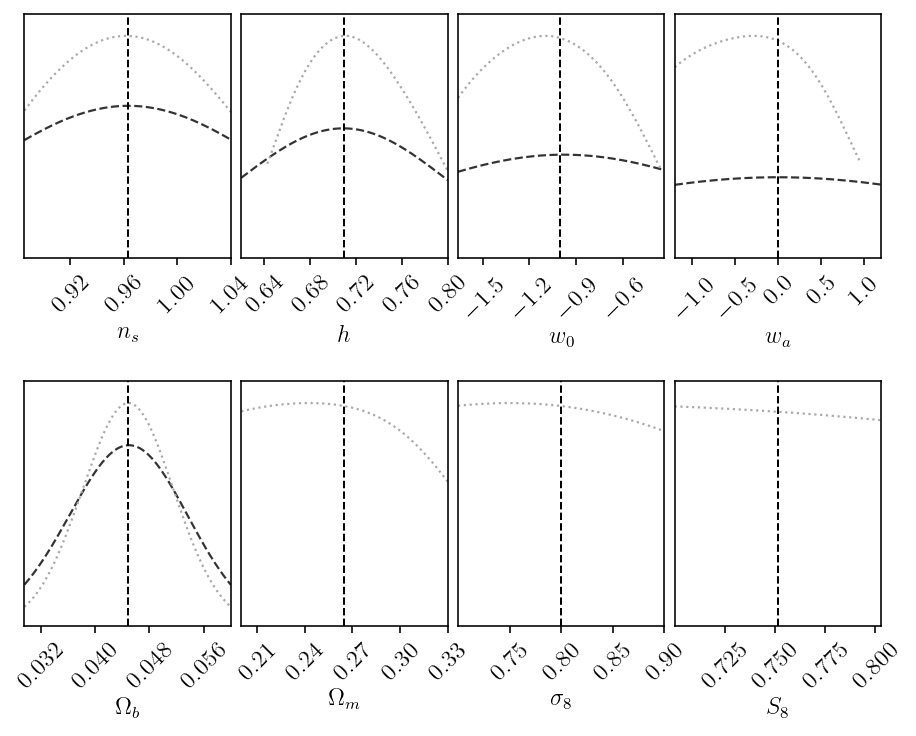

In [11]:
c = ChainConsumer()
c.add_chain(prior_input, parameters=cosmo_names[:5], name="Prior analytic")
c.add_chain(prior, parameters=cosmo_names, name=name_prior)
colors_here = ['k', "#A9A9A9"]
linestyles_here = ["--", ":"]


def call_configure(c):
    c.configure(kde=kde, shade=[True, True, True,False,False,False,False, False], shade_alpha=[0.9, 0.9, 0.9, 0.9, 0.9, 0.9], bar_shade=False,colors=colors_here,legend_kwargs={"fontsize": 12, "loc":'best'},
            legend_color_text=False, tick_font_size=12, label_font_size=12, linewidths=[1.1, 1.1, 1.5, 1.5, 1.5,1.5, 1.5, 1], linestyles=linestyles_here)
    return c

c = call_configure(c)
table = c.analysis.get_latex_table()
print(table)

fig = c.plotter.plot_distributions(figsize=(4,2.), truth=cosmo_truths, extents=extents)
fig.set_size_inches(3. + fig.get_size_inches())
fig.savefig(dir[:-7] + 'plots/%s_%d_prior.png'%(name_plots, burnin),  bbox_inches="tight", dpi=300)
fig.savefig(dir[:-7] + 'plots/%s_%d_prior.pdf'%(name_plots, burnin), bbox_inches="tight")

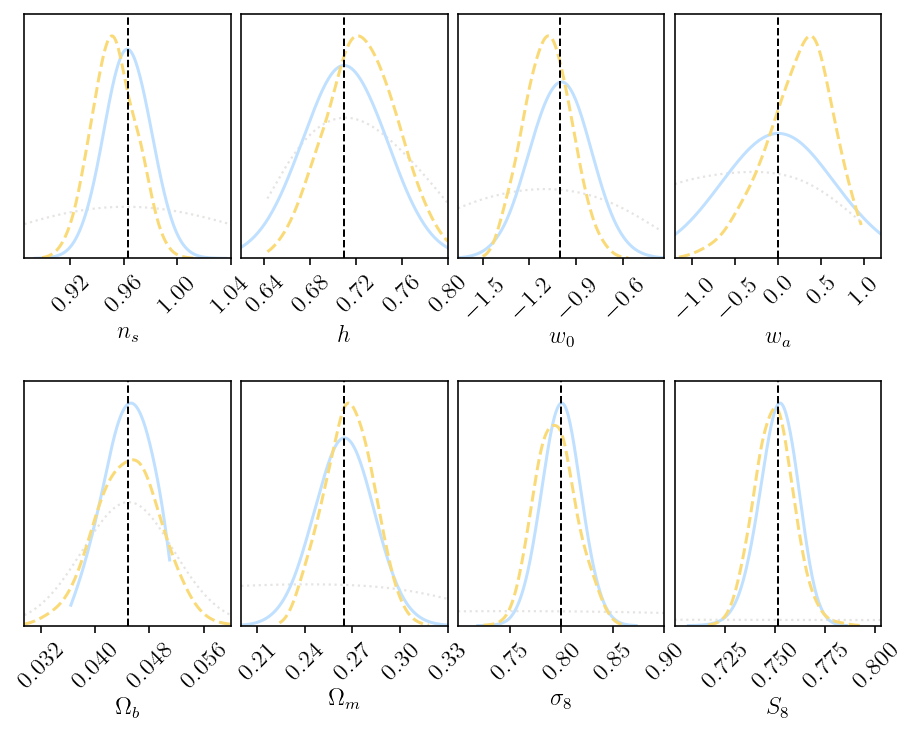

In [12]:
c = ChainConsumer()
c.add_chain(prior, parameters=cosmo_names, name=name_prior)
c.add_chain(srd_shifted, parameters=cosmo_names, name=name_srd)
c.add_chain(gsims, parameters=cosmo_names, name=name_gsims)

colors_here = [color_prior, light_blue, yellow]
linestyles_here = [":", "-", "--"]

def call_configure(c):
    c.configure(kde=kde, shade=[True, False,False,False,False,False, False], shade_alpha=[0.9, 0.9, 0.9, 0.9, 0.9], bar_shade=False,colors=colors_here,legend_kwargs={"fontsize": 12, "loc":'best'},
            legend_color_text=False, tick_font_size=12, label_font_size=12, linewidths=[ 1.1, 1.5,1.5, 1.5, 1.5, 1.5, 1.5], linestyles=linestyles_here)
    return c

c = call_configure(c)

fig = c.plotter.plot_distributions(figsize=(4,2.), truth=cosmo_truths, extents=extents)
fig.set_size_inches(3. + fig.get_size_inches())
fig.savefig(dir[:-7] + 'plots/%s_%d_srd_gsims.png'%(name_plots, burnin),  bbox_inches="tight", dpi=300)
fig.savefig(dir[:-7] + 'plots/%s_%d_srd_gsims.pdf'%(name_plots, burnin), bbox_inches="tight")

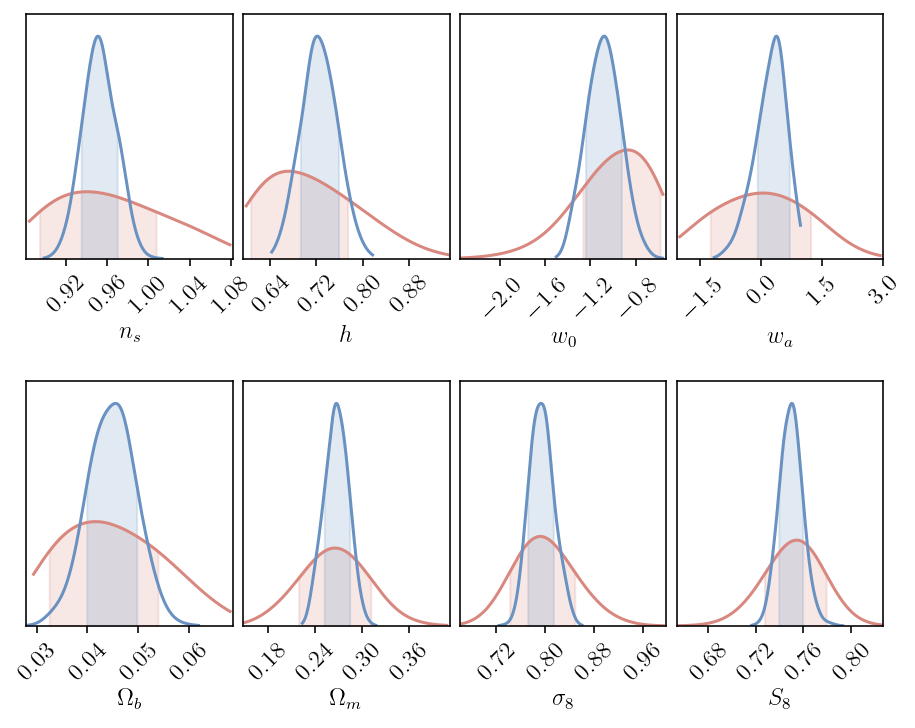

In [20]:
c = ChainConsumer()
c.add_chain(desy3_shifted, parameters=cosmo_names, name='DES Y3', weights= chain_2[:,-1]) #it's multinest, so it needs weights
c.add_chain(gsims, parameters=cosmo_names, name='LSST Y1')

colors_here = [red, blue]
linestyles_here = ["-", "-"]

def call_configure(c):
    c.configure(kde=kde, shade=[True, False,False,False,False,False, False], shade_alpha=[0.9, 0.9, 0.9, 0.9, 0.9], bar_shade=True,colors=colors_here,legend_kwargs={"fontsize": 12, "loc":'best'},
            legend_color_text=False, tick_font_size=12, label_font_size=12, linewidths=[ 1.5,1.5, 1.5, 1.5, 1.5, 1.5], linestyles=linestyles_here)
    return c

c = call_configure(c)

fig = c.plotter.plot_distributions(figsize=(4,2.))#, truth=cosmo_truths, extents=extents)
fig.set_size_inches(3. + fig.get_size_inches())
fig.savefig(dir[:-7] + 'plots/%s_%d_gsims_desy3_noprior.png'%(name_plots, burnin),  bbox_inches="tight", dpi=300)
fig.savefig(dir[:-7] + 'plots/%s_%d_gsims_desy3_noprior.pdf'%(name_plots, burnin), bbox_inches="tight")

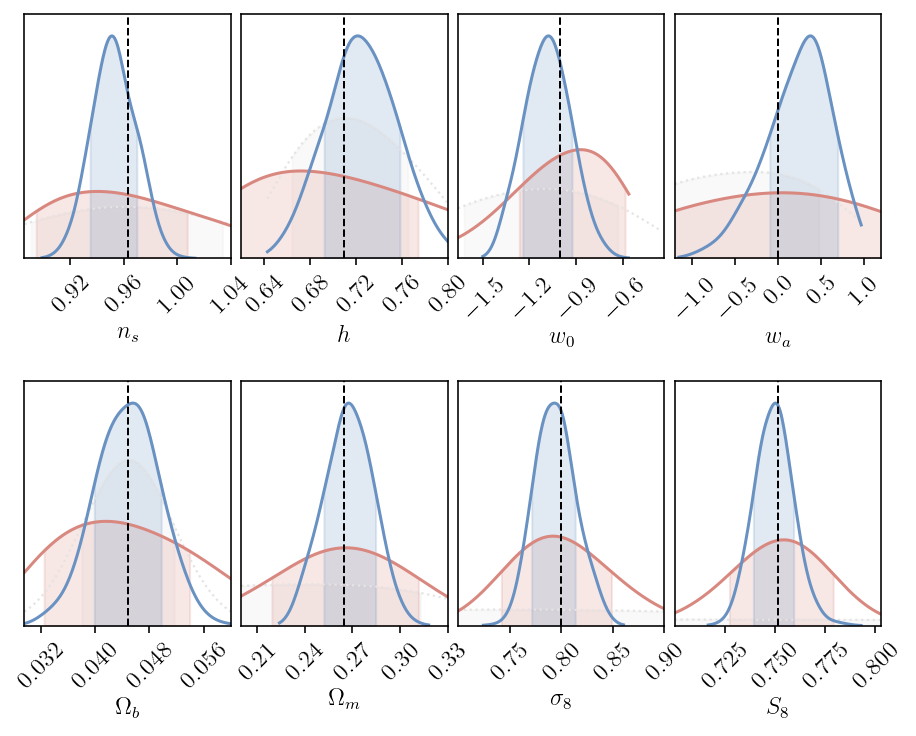

In [22]:
c = ChainConsumer()
c.add_chain(prior, parameters=cosmo_names, name='Prior for LSST Y1')
c.add_chain(desy3_shifted, parameters=cosmo_names, name='DES Y3', weights= chain_2[:,-1]) #it's multinest, so it needs weights
c.add_chain(gsims, parameters=cosmo_names, name='LSST Y1')

colors_here = [color_prior, red, blue]
linestyles_here = [":", "-", "-"]

def call_configure(c):
    c.configure(kde=kde, shade=[True, False,False,False,False,False, False], shade_alpha=[0.9, 0.9, 0.9, 0.9, 0.9], bar_shade=True,colors=colors_here,legend_kwargs={"fontsize": 12, "loc":'best'},
            legend_color_text=False, tick_font_size=12, label_font_size=12, linewidths=[ 1.1, 1.5,1.5, 1.5, 1.5, 1.5, 1.5], linestyles=linestyles_here)
    return c

c = call_configure(c)

fig = c.plotter.plot_distributions(figsize=(4,2.), truth=cosmo_truths, extents=extents)
fig.set_size_inches(3. + fig.get_size_inches())
fig.savefig(dir[:-7] + 'plots/%s_%d_gsims_desy3.png'%(name_plots, burnin),  bbox_inches="tight", dpi=300)
fig.savefig(dir[:-7] + 'plots/%s_%d_gsims_desy3.pdf'%(name_plots, burnin), bbox_inches="tight")

\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{ccccccccc}
        \hline
		Model & $n_s$ & $h$ & $w_0$ & $w_a$ & $\Omega_b$ & $\Omega_m$ & $\sigma_8$ & $S_8$ \\ 
		\hline
		Prior (for this work) & $0.962^{+0.072}_{-0.071}$ & $0.711^{+0.054}_{-0.047}$ & $-1.10^{+0.46}_{-0.53}$ & $-0.29^{+0.76}_{-1.07}$ & $\left( 44.8\pm 6.8 \right) \times 10^{-3}$ & $0.242^{+0.071}_{-0.095}$ & $0.75^{+0.25}_{-0.33}$ & $0.61^{+0.34}_{-0.35}$ \\ 
		Gaussian sims TXPipe + FireCrown & $0.951^{+0.019}_{-0.016}$ & $0.722^{+0.037}_{-0.029}$ & $-1.08^{+0.15}_{-0.17}$ & $0.37^{+0.32}_{-0.47}$ & $\left( 45.6^{+4.1}_{-5.7} \right) \times 10^{-3}$ & $0.267^{+0.017}_{-0.015}$ & $0.793^{+0.020}_{-0.022}$ & $\left( 750.0^{+9.3}_{-10.8} \right) \times 10^{-3}$ \\ 
		Forecasted in SRD & $0.963^{+0.018}_{-0.017}$ & $0.709^{+0.039}_{-0.036}$ & $-0.99^{+0.19}_{-0.21}$ & $0.00^{+0.67}_{-0.66}$ & $\left( 45.3^{+3.8}_{-3.7} \right) \times 10^{-3}$ & $0.265\pm 0.019$ & $0.801^{+0.0

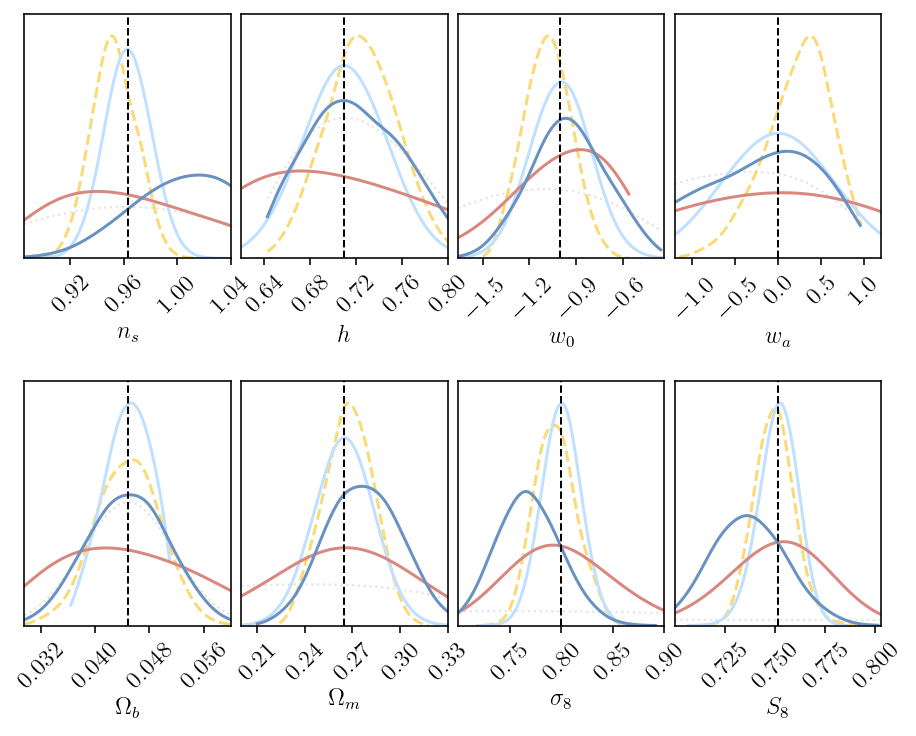

In [16]:
c = ChainConsumer()
c.add_chain(prior, parameters=cosmo_names, name=name_prior)
c.add_chain(gsims, parameters=cosmo_names, name=name_gsims)
c.add_chain(srd_shifted, parameters=cosmo_names, name=name_srd)
c.add_chain(desy3_shifted, parameters=cosmo_names, name='DES Y3', weights= chain_2[:,-1]) #it's multinest, so it needs weights
c.add_chain(cosmodc2, parameters=cosmo_names, name=name_cosmodc2)

colors_here = [color_prior, yellow, light_blue, red, blue]
linestyles_here = [":", "--", "-", "-","-", "-","-", "-", "--",":"]

def call_configure(c):
    c.configure(kde=kde, shade=[True, True, True,False,False,False,False, False], shade_alpha=[0.9, 0.9, 0.9, 0.9, 0.9, 0.9], bar_shade=False,colors=colors_here,legend_kwargs={"fontsize": 12, "loc":'best'},
            legend_color_text=False, tick_font_size=12, label_font_size=12, linewidths=[1.1, 1.5, 1.5, 1.5, 1.5,1.5, 1.5, 1], linestyles=linestyles_here)
    return c

c = call_configure(c)
table = c.analysis.get_latex_table()
print(table)

fig = c.plotter.plot_distributions(figsize=(4,2.), truth=cosmo_truths, extents=extents)
fig.set_size_inches(3. + fig.get_size_inches())
fig.savefig(dir[:-7] + 'plots/%s_%d_all.png'%(name_plots, burnin),  bbox_inches="tight", dpi=300)
fig.savefig(dir[:-7] + 'plots/%s_%d_all.pdf'%(name_plots, burnin), bbox_inches="tight")

\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{ccccccccc}
        \hline
		Model & $n_s$ & $h$ & $w_0$ & $w_a$ & $\Omega_b$ & $\Omega_m$ & $\sigma_8$ & $S_8$ \\ 
		\hline
		Prior (for this work) & $0.962^{+0.072}_{-0.071}$ & $0.711^{+0.054}_{-0.047}$ & $-1.10^{+0.46}_{-0.53}$ & $-0.29^{+0.76}_{-1.07}$ & $\left( 44.8\pm 6.8 \right) \times 10^{-3}$ & $0.242^{+0.071}_{-0.095}$ & $0.75^{+0.25}_{-0.33}$ & $0.61^{+0.34}_{-0.35}$ \\ 
		Gaussian sims TXPipe + FireCrown & $0.951^{+0.019}_{-0.016}$ & $0.722^{+0.037}_{-0.029}$ & $-1.08^{+0.15}_{-0.17}$ & $0.37^{+0.32}_{-0.47}$ & $\left( 45.6^{+4.1}_{-5.7} \right) \times 10^{-3}$ & $0.267^{+0.017}_{-0.015}$ & $0.793^{+0.020}_{-0.022}$ & $\left( 750.0^{+9.3}_{-10.8} \right) \times 10^{-3}$ \\ 
		Forecasted in SRD & $0.963^{+0.018}_{-0.017}$ & $0.709^{+0.039}_{-0.036}$ & $-0.99^{+0.19}_{-0.21}$ & $0.00^{+0.67}_{-0.66}$ & $\left( 45.3^{+3.8}_{-3.7} \right) \times 10^{-3}$ & $0.265\pm 0.019$ & $0.801^{+0.0

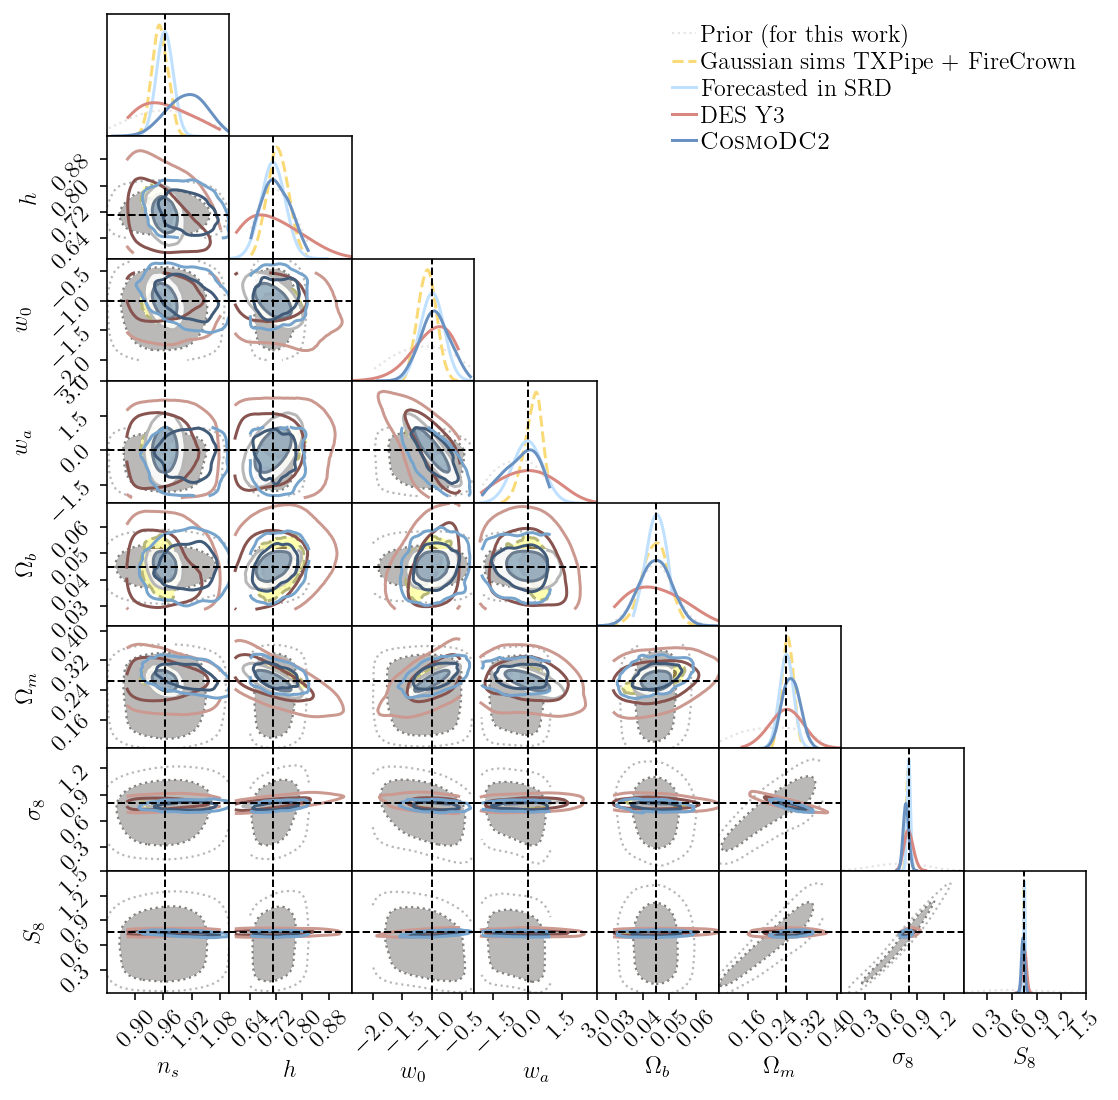

In [21]:
c = ChainConsumer()
c.add_chain(prior, parameters=cosmo_names, name=name_prior)
c.add_chain(gsims, parameters=cosmo_names, name=name_gsims)
c.add_chain(srd_shifted, parameters=cosmo_names, name=name_srd)
c.add_chain(desy3_shifted, parameters=cosmo_names, name='DES Y3', weights= chain_2[:,-1]) #it's multinest, so it needs weights
c.add_chain(cosmodc2, parameters=cosmo_names, name=name_cosmodc2)

colors_here = [color_prior, yellow, light_blue, red, blue]
linestyles_here = [":", "--", "-", "-","-", "-","-", "-", "--",":"]

def call_configure(c):
    c.configure(kde=kde, shade=[True, True, True,False,False,False,False, False], shade_alpha=[0.9, 0.9, 0.9, 0.9, 0.9, 0.9], bar_shade=False,colors=colors_here,legend_kwargs={"fontsize": 12, "loc":'best'},
            legend_color_text=False, tick_font_size=12, label_font_size=12, linewidths=[1.1, 1.5, 1.5, 1.5, 1.5,1.5, 1.5, 1], linestyles=linestyles_here)
    return c

c = call_configure(c)
table = c.analysis.get_latex_table()
print(table)

fig = c.plotter.plot(figsize=(5,5.), truth=cosmo_truths)
fig.set_size_inches(3. + fig.get_size_inches())
fig.savefig(dir[:-7] + 'plots/%s_%d_all2D.png'%(name_plots, burnin),  bbox_inches="tight", dpi=300)
fig.savefig(dir[:-7] + 'plots/%s_%d_all2D.pdf'%(name_plots, burnin), bbox_inches="tight")